In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
# Path to the data folder
data_folder = "data"
dataset_file = f"{data_folder}/dataset_3_1.hdf5"

In [3]:
# Inspect HDF5 file structure
def inspect_hdf5_structure(file_path):
    with h5py.File(file_path, 'r') as f:
        print("HDF5 File Structure:")
        f.visit(print)  # Prints all groups and datasets in the file

inspect_hdf5_structure(dataset_file)

HDF5 File Structure:
incident_energies
showers


In [4]:
# Load the HDF5 dataset
def load_dataset(file_path):
    with h5py.File(file_path, 'r') as f:
        showers = np.array(f['showers'])  
        energies = np.array(f['incident_energies'])  
    return showers, energies

In [5]:
# Preprocessing: Normalize the voxel intensities
def normalize_data(showers):
    return (showers - np.mean(showers, axis=0)) / np.std(showers, axis=0)

In [6]:
# Visualize energy distribution
def plot_energy_distribution(energies):
    plt.figure(figsize=(8, 6))
    sns.histplot(energies, bins=50, kde=True, color="blue")
    plt.title("Energy Distribution (Log-Uniform)")
    plt.xlabel("Energy (GeV)")
    plt.ylabel("Frequency")
    plt.grid()
    plt.show()

In [7]:
# Visualize a single shower
def plot_shower_voxels(shower, layer=22):
    # Reshape a single shower into (45, 18, 50)
    shower_reshaped = shower.reshape(45, 18, 50)
    plt.figure(figsize=(10, 8))
    sns.heatmap(shower_reshaped[layer], cmap="viridis")
    plt.title(f"Voxel Intensities for Layer {layer}")
    plt.xlabel("Angular Bins")
    plt.ylabel("Radial Bins")
    plt.show()

In [8]:
# Summarize dataset statistics
def dataset_statistics(showers):
    stats = {
        "Total Energy (mean)": showers.sum(axis=1).mean(),
        "Total Energy (std)": showers.sum(axis=1).std(),
        "Non-zero Voxels (mean)": (showers > 0).sum(axis=1).mean(),
        "Non-zero Voxels (std)": (showers > 0).sum(axis=1).std(),
    }
    return pd.DataFrame([stats])


In [9]:
# Main execution
showers, energies = load_dataset(dataset_file)

In [10]:
def normalize_data_in_chunks(showers, chunk_size=1000):
    """
    Normalize data in chunks to prevent memory overload.
    :param showers: 2D numpy array of showers (samples x voxels).
    :param chunk_size: Number of samples to process per chunk.
    :return: Normalized showers as a numpy array.
    """
    # Compute global mean and std in a memory-efficient way
    mean = np.mean(showers, axis=0)
    std = np.std(showers, axis=0)
    
    # Avoid division by zero
    std[std == 0] = 1.0

    # Process data in chunks
    normalized_showers = np.zeros_like(showers)
    for i in range(0, showers.shape[0], chunk_size):
        chunk = showers[i:i + chunk_size]
        normalized_showers[i:i + chunk_size] = (chunk - mean) / std
    return normalized_showers

# Normalize the data
normalized_showers = normalize_data_in_chunks(showers, chunk_size=1000)


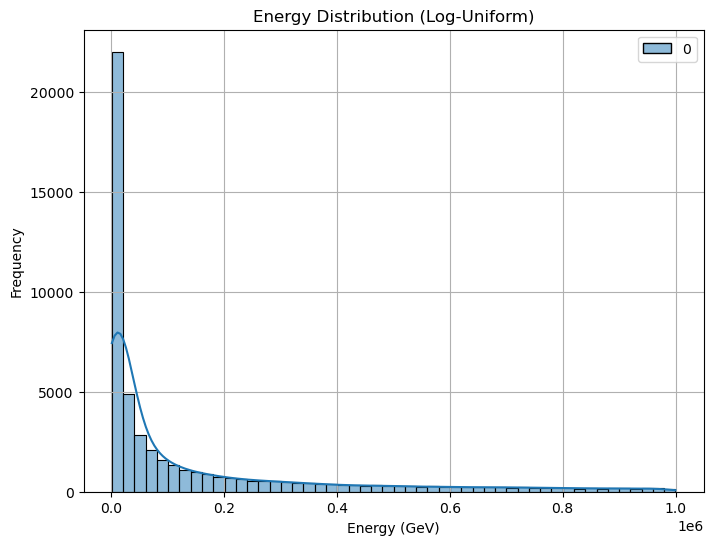

In [11]:
# Plot energy distribution
plot_energy_distribution(energies)

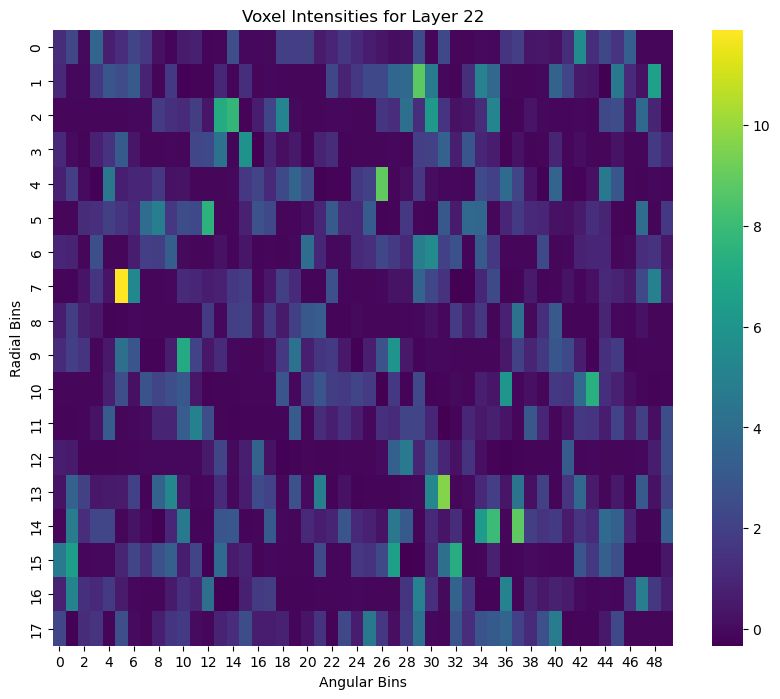

In [12]:
# Visualize a single shower (e.g., first sample, layer 22)
plot_shower_voxels(normalized_showers[0], layer=22)

In [14]:
# Display dataset statistics
stats_df = dataset_statistics(showers)
print("Dataset Statistics:")
stats_df

Dataset Statistics:


,Total Energy (mean),Total Energy (std),Non-zero Voxels (mean),Non-zero Voxels (std)
0,112862.220424,177578.802322,4202.8056,4654.965456


In [15]:
def summarize_energies(energies):
    print(f"Energy Statistics:")
    print(f"Min: {np.min(energies):.2f} GeV")
    print(f"Max: {np.max(energies):.2f} GeV")
    print(f"Mean: {np.mean(energies):.2f} GeV")
    print(f"Std Dev: {np.std(energies):.2f} GeV")
    print(f"Median: {np.median(energies):.2f} GeV")

summarize_energies(energies)


Energy Statistics:
Min: 1000.51 GeV
Max: 999938.71 GeV
Mean: 144764.32 GeV
Std Dev: 227503.30 GeV
Median: 31519.61 GeV


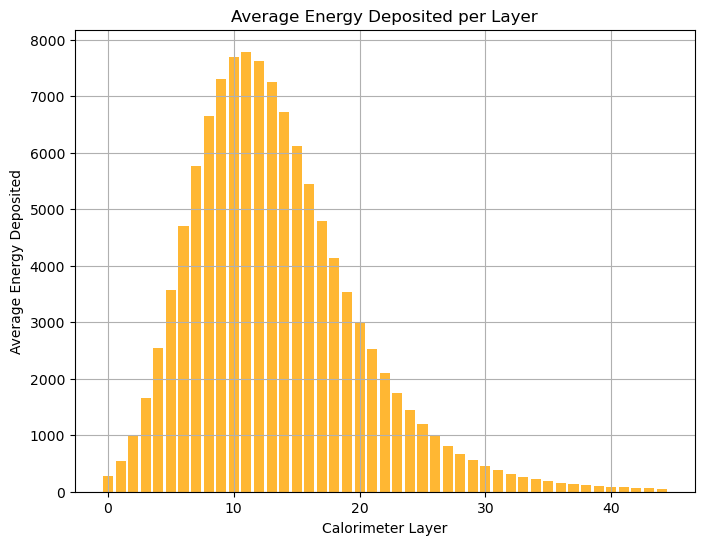

In [16]:
def layer_energy_distribution(showers):
    # Reshape to (n_samples, 45, 18, 50)
    reshaped_showers = showers.reshape(-1, 45, 18, 50)
    # Sum across radial and angular bins for each layer
    layer_energies = reshaped_showers.sum(axis=(2, 3)).mean(axis=0)
    
    plt.figure(figsize=(8, 6))
    plt.bar(range(45), layer_energies, color='orange', alpha=0.8)
    plt.title("Average Energy Deposited per Layer")
    plt.xlabel("Calorimeter Layer")
    plt.ylabel("Average Energy Deposited")
    plt.grid()
    plt.show()

layer_energy_distribution(showers)


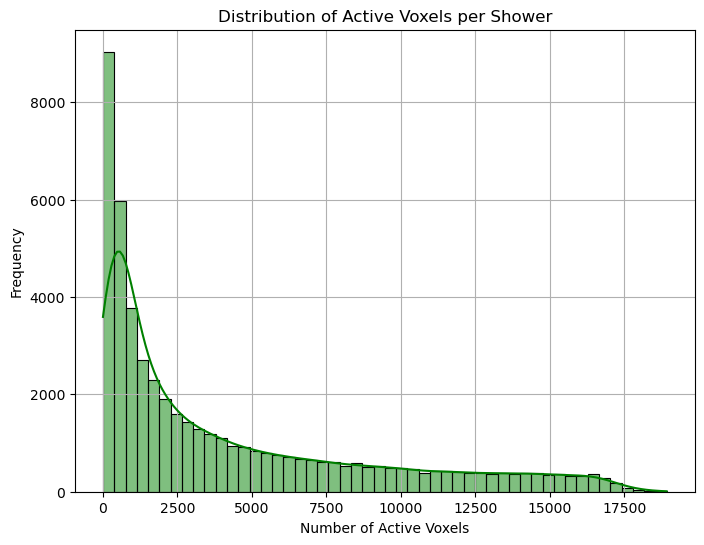

In [17]:
def active_voxel_distribution(showers):
    active_voxels = (showers > 0).sum(axis=1)
    plt.figure(figsize=(8, 6))
    sns.histplot(active_voxels, bins=50, kde=True, color="green")
    plt.title("Distribution of Active Voxels per Shower")
    plt.xlabel("Number of Active Voxels")
    plt.ylabel("Frequency")
    plt.grid()
    plt.show()

active_voxel_distribution(showers)


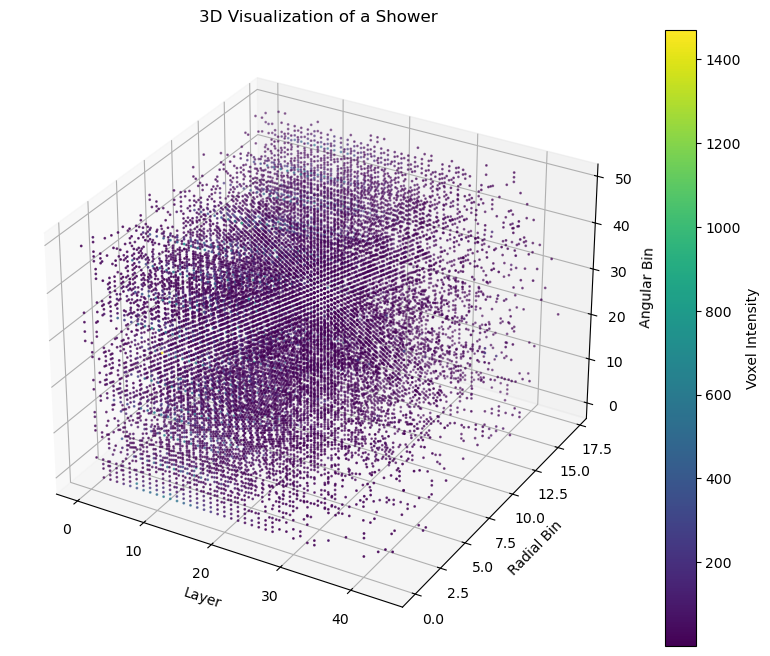

In [18]:
from mpl_toolkits.mplot3d import Axes3D

def visualize_shower_3d(shower):
    # Reshape to (45, 18, 50)
    reshaped_shower = shower.reshape(45, 18, 50)
    x, y, z = np.indices(reshaped_shower.shape)
    
    # Flatten and filter non-zero voxels
    x = x.flatten()
    y = y.flatten()
    z = z.flatten()
    values = reshaped_shower.flatten()
    mask = values > 0  # Filter non-zero voxels
    
    # 3D scatter plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(x[mask], y[mask], z[mask], c=values[mask], cmap='viridis', s=1)
    ax.set_title("3D Visualization of a Shower")
    ax.set_xlabel("Layer")
    ax.set_ylabel("Radial Bin")
    ax.set_zlabel("Angular Bin")
    fig.colorbar(scatter, ax=ax, label="Voxel Intensity")
    plt.show()

visualize_shower_3d(showers[0])


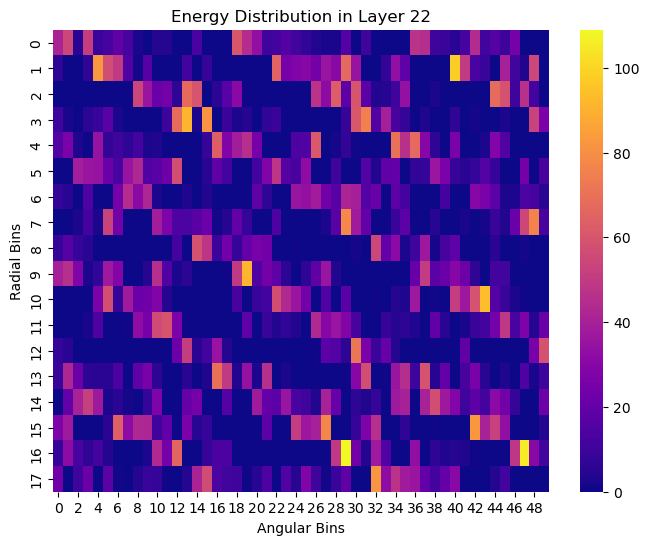

In [19]:
def plot_layer_heatmap(shower, layer=22):
    reshaped_shower = shower.reshape(45, 18, 50)
    plt.figure(figsize=(8, 6))
    sns.heatmap(reshaped_shower[layer], cmap="plasma", cbar=True)
    plt.title(f"Energy Distribution in Layer {layer}")
    plt.xlabel("Angular Bins")
    plt.ylabel("Radial Bins")
    plt.show()

plot_layer_heatmap(showers[0], layer=22)
